# Lab 2: Cats vs Dogs

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

This lab is partially based on an assignment developed by Prof. Jonathan Rose and Harris Chan.

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://drive.google.com/file/d/1MgHLy8mqeaCT31Jl-Tv6X_oQlyoaTOew/view?usp=sharing

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [ ]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [ ]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

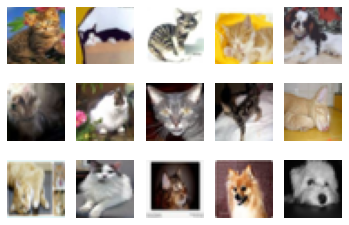

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [ ]:
print("The number of training examples for the combined classes is", 
      len(train_loader))
print("The number of validation examples for the combined classes is", 
      len(val_loader))
print("The number of test examples for the combined classes is", 
      len(test_loader))

The number of training examples for the combined classes is 8000
The number of validation examples for the combined classes is 2000
The number of test examples for the combined classes is 2000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

**Answer:**

A validation set is needed when training a model because we require some way to verify the results of the trained model. By tracking the validation set loss/error, we can make more informed decisions when modifying the model architecture and tuning hyperparameters. If we judge the performance of our models using the training set loss/error, we may overfit our models to the training set and not generalize well to a brand-new data set. 

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [ ]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x  

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [ ]:
size = 0
for param in small_net.parameters():
    print(param.shape)
    size += param.numel()
print("The total number of parameters in small_net is", size, "\n")

size = 0
for param in large_net.parameters():
    print(param.shape)
    size += param.numel()
print("The total number of parameters in large_net is", size)

torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])
The total number of parameters in small_net is 386 

torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])
The total number of parameters in large_net is 9705


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [ ]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

**Answer:**

The default values of the parameters are `batch_size=64`, `learning_rate=0.01`, 
and `num_epochs=30`.

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [ ]:
train_net(small_net, num_epochs=5)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.446375, Train loss: 0.6813716783523559 |Validation err: 0.3865, Validation loss: 0.6602997500449419
Epoch 2: Train err: 0.37325, Train loss: 0.6497629323005676 |Validation err: 0.3845, Validation loss: 0.6575995869934559
Epoch 3: Train err: 0.359875, Train loss: 0.6388978385925292 |Validation err: 0.3495, Validation loss: 0.6291275043040514
Epoch 4: Train err: 0.346375, Train loss: 0.6246587996482849 |Validation err: 0.356, Validation loss: 0.6221408396959305
Epoch 5: Train err: 0.334375, Train loss: 0.6153830280303955 |Validation err: 0.3275, Validation loss: 0.6188967823982239
Finished Training
Total time elapsed: 18.12 seconds


**Answer:**

The files written to disk are:
* model_small_bs64_lr0.01_epoch0 - saved model checkpoint for the first epoch
* model_small_bs64_lr0.01_epoch1 - saved model checkpoint for the second epoch
* model_small_bs64_lr0.01_epoch2 - saved model checkpoint for the third epoch
* model_small_bs64_lr0.01_epoch3 - saved model checkpoint for the fourth epoch
* model_small_bs64_lr0.01_epoch4 - saved model checkpoint for the fifth epoch
* model_small_bs64_lr0.01_epoch4_train_err.csv - training error for each epoch
* model_small_bs64_lr0.01_epoch4_train_loss.csv - training loss for each epoch
* model_small_bs64_lr0.01_epoch4_val_err.csv - validation error for each epoch
* model_small_bs64_lr0.01_epoch4_val_loss.csv - validation loss for each epoch

### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
small_net = SmallNet() # Reconstruct model since it was trained in Part (c)
train_net(small_net)
train_net(large_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.446375, Train loss: 0.6813716783523559 |Validation err: 0.3865, Validation loss: 0.6602997500449419
Epoch 2: Train err: 0.37325, Train loss: 0.6497629323005676 |Validation err: 0.3845, Validation loss: 0.6575995869934559
Epoch 3: Train err: 0.359875, Train loss: 0.6388978385925292 |Validation err: 0.3495, Validation loss: 0.6291275043040514
Epoch 4: Train err: 0.346375, Train loss: 0.6246587996482849 |Validation err: 0.356, Validation loss: 0.6221408396959305
Epoch 5: Train err: 0.334375, Train loss: 0.6153830280303955 |Validation err: 0.3275, Validation loss: 0.6188967823982239
Epoch 6: Train err: 0.318, Train loss: 0.6036732516288758 |Validation err: 0.339, Validation loss: 0.6094125052914023
Epoch 7: Train err: 0.315625, Train loss: 0.5944745948314667 |Validation err: 0.329, Validation loss: 0.5974238961935043
Epoch 8: Train err: 0.3085, Train loss: 0.5829453563690186 |Validation err: 0

**Answer:**

As shown in the code above, the total time elapsed for training `small_net` is `109.83` seconds and the total time elapsed for training `large_net` is `122.63` seconds. `large_net` took longer to train because it has significantly more parameters to be updated compared to `small_net` as shown in Part (a), which also means that it has a higher model complexity or capacity.



### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

Small Network


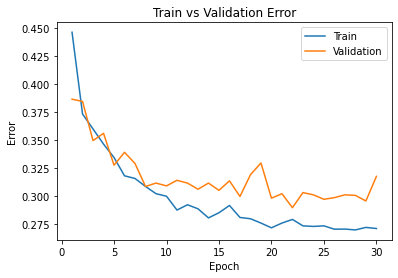

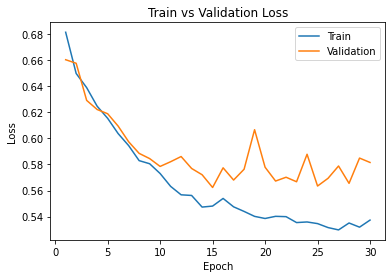

In [ ]:
print("Small Network")
model_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

Large Network


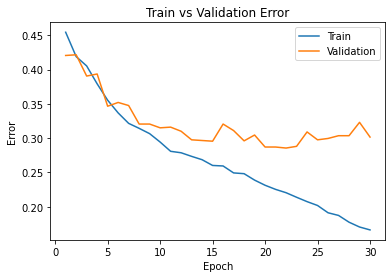

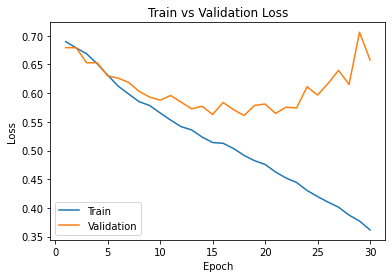

In [ ]:
print("Large Network")
model_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

**Answer:**

The main differences between the training curves of `small_net` and `large_net` are that:

1.   The `small_net` training error decreases much more rapidly at lower epochs compared to `large_net`.
2.   The `large_net` training curves are much less noisy compared to `small_net`. 

For `small_net`, underfitting occurs at lower epochs (0-17) since both training error/loss and validation error/loss decrease as the number of epochs increases. Underfitting becomes less prominent for `small_net` as the number of epochs approaches 30 since the error and loss curves start to flatten out. 

For `large_net`, underfitting again occurs at lower epochs (0-17) since both training error/loss and validation error/loss decrease as the number of epochs increases. However, the model starts to overfit for larger numbers of epochs (18-29) since validation error/loss flattens out and increases as training error/loss continues to decrease. 

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360013961792 |Validation err: 0.467, Validation loss: 0.6924686580896378
Epoch 2: Train err: 0.448625, Train loss: 0.6922589712142945 |Validation err: 0.4305, Validation loss: 0.691649341955781
Epoch 3: Train err: 0.43575, Train loss: 0.6916067280769348 |Validation err: 0.4285, Validation loss: 0.690854424610734
Epoch 4: Train err: 0.43, Train loss: 0.690861343383789 |Validation err: 0.424, Validation loss: 0.6896595880389214
Epoch 5: Train err: 0.434125, Train loss: 0.6899195008277893 |Validation err: 0.4195, Validation loss: 0.6886935643851757
Epoch 6: Train err: 0.43575, Train loss: 0.6887411961555481 |Validation err: 0.4195, Validation loss: 0.6867824867367744
Epoch 7: Train err: 0.437125, Train loss: 0.6873774147033691 |Validation err: 0.4185, Validation loss: 0.6851982977241278
Epoch 8: Train err: 0.4375, Train loss: 0.6859278454780579 |Validation err: 0.412,

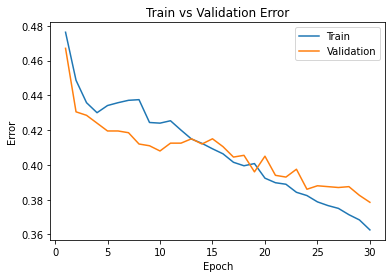

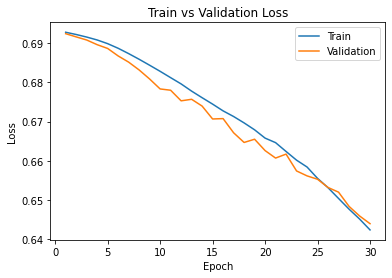

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, learning_rate=0.001)
model_path = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(model_path)

**Answer:**

The model takes roughly the same amount of time to train compared to the default settings. 

By lowering the learning rate from `0.01` to `0.001`, the size of each gradient descent step is smaller, which makes the error/loss to decrease slower compared to the default settings. As a result, the model no longer overfits for larger numbers of epochs.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4295, Train loss: 0.67437779712677 |Validation err: 0.3595, Validation loss: 0.6350857093930244
Epoch 2: Train err: 0.36075, Train loss: 0.6411805458068848 |Validation err: 0.3535, Validation loss: 0.6361209936439991
Epoch 3: Train err: 0.365125, Train loss: 0.6321813461780548 |Validation err: 0.3385, Validation loss: 0.6056603882461786
Epoch 4: Train err: 0.352625, Train loss: 0.6233456182479858 |Validation err: 0.3575, Validation loss: 0.6362800188362598
Epoch 5: Train err: 0.34075, Train loss: 0.6108013873100281 |Validation err: 0.3305, Validation loss: 0.6064918786287308
Epoch 6: Train err: 0.323375, Train loss: 0.5921835997104645 |Validation err: 0.317, Validation loss: 0.5967769594863057
Epoch 7: Train err: 0.3145, Train loss: 0.5817317583560944 |Validation err: 0.3365, Validation loss: 0.6204487886279821
Epoch 8: Train err: 0.29825, Train loss: 0.5660300073623658 |Validation err: 0.

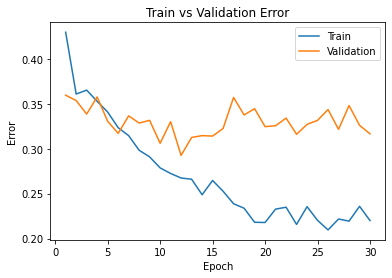

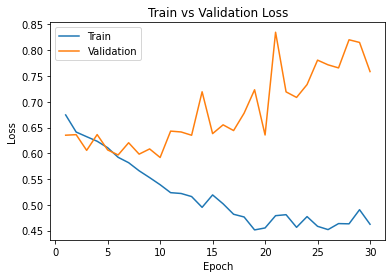

In [ ]:
large_net = LargeNet()
train_net(large_net, learning_rate=0.1)
model_path = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(model_path)

**Answer:**

The model takes roughly the same amount of time to train compared to the default settings. 

By increasing the learning rate from `0.01` to `0.1`, the size of each gradient descent step is larger, which makes the error/loss to decrease faster compared to the default settings. As a result, the model starts to overfit much earlier compared to the default model. 

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.6924104019999504 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500590741634 |Validation err: 0.4265, Validation loss: 0.6909129917621613
Epoch 4: Train err: 0.433625, Train loss: 0.6908449940383434 |Validation err: 0.424, Validation loss: 0.6897870451211929
Epoch 5: Train err: 0.434, Train loss: 0.6896935552358627 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.688353206962347 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871677339077 |Validation err: 0.426, Validation loss: 0.6836968809366226
Epoch 8: Train err: 0.43525, Train loss: 0.6849770769476891 |Validation err: 0.4115, Va

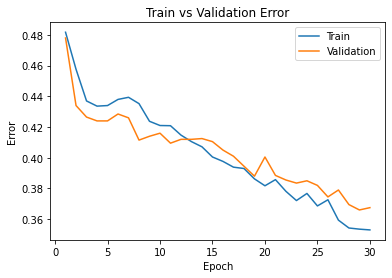

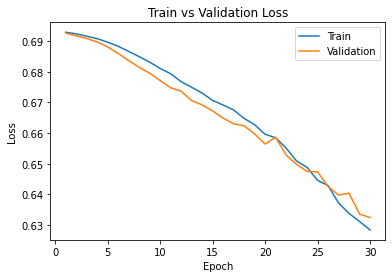

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=512)
model_path = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

**Answer:**

The model takes less time to train compared to the default settings. 

By increasing the batch size from `64` to `512`, the model no longer overfits for larger numbers of epochs. However, the new model results in slightly higher training error/loss and validation error compared to the default settings. 

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774994022846222 |Validation err: 0.382, Validation loss: 0.6513170118331909
Epoch 2: Train err: 0.369, Train loss: 0.639639899969101 |Validation err: 0.3465, Validation loss: 0.6161113576889038
Epoch 3: Train err: 0.34375, Train loss: 0.6098222947120666 |Validation err: 0.3325, Validation loss: 0.6260210764408112
Epoch 4: Train err: 0.314375, Train loss: 0.5849691489338875 |Validation err: 0.34, Validation loss: 0.6044013917446136
Epoch 5: Train err: 0.301125, Train loss: 0.5689119303822517 |Validation err: 0.3125, Validation loss: 0.576918310880661
Epoch 6: Train err: 0.281, Train loss: 0.5452213581204415 |Validation err: 0.308, Validation loss: 0.5708447456359863
Epoch 7: Train err: 0.270875, Train loss: 0.5272981298565864 |Validation err: 0.307, Validation loss: 0.5854293291568756
Epoch 8: Train err: 0.259375, Train loss: 0.5070905526578426 |Validation err: 0.313, 

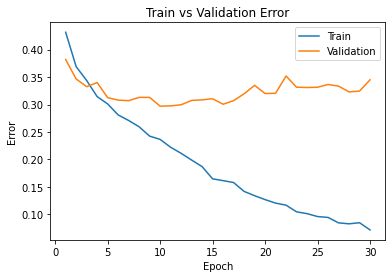

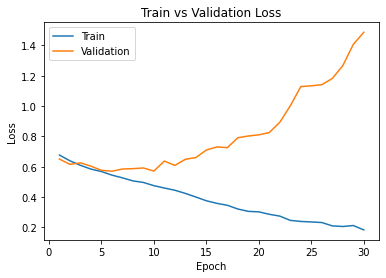

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=16)
model_path = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

**Answer:**

The model takes more time to train compared to the default settings. 

By decreasing the batch size from `64` to `16`, the model starts to overfit much earlier. However, the new model results in a lower training error/loss but a much higher validation loss compared to the default settings. 

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

**Answer:**

The set of hyperparameter values I have chosen is `(large_net, batch_size=512, learning_rate=0.001)`.

I chose `large_net` because based on Part 2(f), it is observed that `large_net` is less susceptible to noise compared to `small_net`. However, it will overfit at larger numbers of epochs so the remaining hyperparameters will need to be adjusted to compensate for this.

I chose `batch_size=512` and `learning_rate=0.001` because based on Part 3(a) and Part 3(c), increasing the batch size and decreasing the learning rate can help reduce overfitting at larger numbers of epochs.

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48825, Train loss: 0.6930677480995655 |Validation err: 0.4955, Validation loss: 0.6931362152099609
Epoch 2: Train err: 0.483125, Train loss: 0.692995510995388 |Validation err: 0.4945, Validation loss: 0.6930360496044159
Epoch 3: Train err: 0.480375, Train loss: 0.6929280497133732 |Validation err: 0.493, Validation loss: 0.6929539889097214
Epoch 4: Train err: 0.477, Train loss: 0.6928808391094208 |Validation err: 0.4885, Validation loss: 0.692870706319809
Epoch 5: Train err: 0.473375, Train loss: 0.692774411290884 |Validation err: 0.4835, Validation loss: 0.6927504986524582
Epoch 6: Train err: 0.469, Train loss: 0.6926896274089813 |Validation err: 0.472, Validation loss: 0.6926551759243011
Epoch 7: Train err: 0.46325, Train loss: 0.692620363086462 |Validation err: 0.47, Validation loss: 0.6925524920225143
Epoch 8: Train err: 0.46225, Train loss: 0.6925435550510883 |Validation err: 0.463, Va

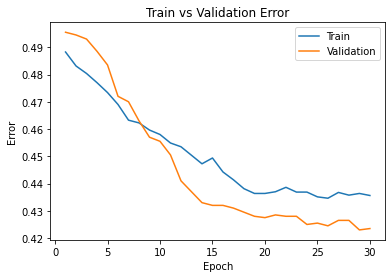

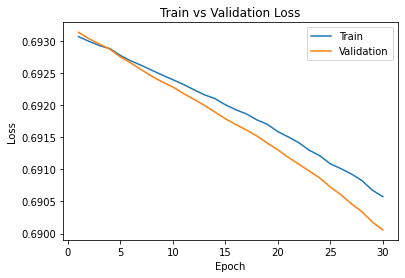

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=512, learning_rate=0.001)
model_path = get_model_name("large", batch_size=512, learning_rate=0.001, epoch=29)
plot_training_curve(model_path)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

**Answer:**

Based on the results of Part (a), the improved set of hyperparameter values I have chosen is `(large_net, batch_size=512, learning_rate=0.05, num_epochs=19)`.

Despite the fact that increasing the batch size and decreasing the learning rate helped reduce overfitting, the combined effect also greatly reduced the rate at which error/loss decreases. As a result, I decided to increase the learning rate to `0.05` and let the error/loss decrease more rapidly. 

Increasing the learning rate introduced some minor overfitting at the larger epoch range, specifically epochs 20-30. So, I chose to reduce the number of epochs to `19` as well. 

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.49375, Train loss: 0.6928116045892239 |Validation err: 0.423, Validation loss: 0.6905251741409302
Epoch 2: Train err: 0.443125, Train loss: 0.688632857054472 |Validation err: 0.427, Validation loss: 0.6822147369384766
Epoch 3: Train err: 0.44325, Train loss: 0.6826433055102825 |Validation err: 0.4225, Validation loss: 0.6766358017921448
Epoch 4: Train err: 0.42125, Train loss: 0.6766663640737534 |Validation err: 0.3995, Validation loss: 0.6669993251562119
Epoch 5: Train err: 0.39575, Train loss: 0.665775328874588 |Validation err: 0.4045, Validation loss: 0.6614061146974564
Epoch 6: Train err: 0.38675, Train loss: 0.6580385267734528 |Validation err: 0.39, Validation loss: 0.6528950929641724
Epoch 7: Train err: 0.376, Train loss: 0.6504689082503319 |Validation err: 0.367, Validation loss: 0.6434173136949539
Epoch 8: Train err: 0.37125, Train loss: 0.63962047919631 |Validation err: 0.3495, Va

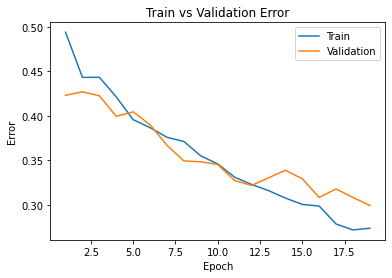

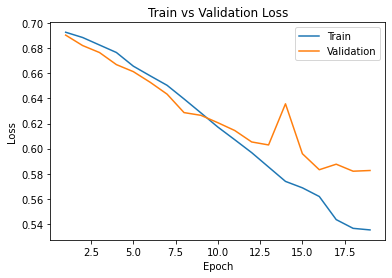

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=512, learning_rate=0.05, num_epochs=19)
model_path = get_model_name("large", batch_size=512, learning_rate=0.05, epoch=18)
plot_training_curve(model_path)

## Part 5. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [ ]:
net = LargeNet()
model_path = get_model_name(net.name, batch_size=512, learning_rate=0.05, epoch=18)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

**Answer:**

I chose `large_net` because based on Part 2(f), it is observed that `large_net` is less susceptible to noise compared to `small_net`. However, it will overfit at larger numbers of epochs so the remaining hyperparameters will need to be adjusted to compensate for this.

I chose `batch_size=512` because based on Part 3(a), increasing the batch size can help reduce overfitting at larger numbers of epochs and reduce model training time.

I chose `learning_rate=0.05` so the model can learn faster by letting the error/loss decrease more rapidly. 

I chose `num_epochs=19` because the model overfits at greater numbers of epochs. 

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [ ]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=512)
criterion = nn.BCEWithLogitsLoss()
err, loss = evaluate(net, test_loader, criterion)
print("The test classification error is", err, "and the test loss is", loss)

Files already downloaded and verified
Files already downloaded and verified
The test classification error is 0.304 and the test loss is 0.5739964246749878


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

**Answer:**

The test classification error is `0.304` and the validation error is `0.2995`. While the errors are quite similar, the test classification error is indeed slightly higher compared to the validation error. This is expected because the test error is an indication of how the model will perform on a new data set. The test set has only been shown to the model for the first time while the validation set has been used quite extensively when searching for the best hyperparameters. 

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

**Answer:**

The test data set is used at the very end because it is utilized to provide a realistic estimate of how the model will perform on a brand-new data set. It is important that the test data is used as little as possible because it is crucial to not make any neural network architecture decisions based on test data or test accuracy. Otherwise, bias towards the test data set will be introduced and the model will be overfitted to the test data. 

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

In [ ]:
class Pigeon(nn.Module):
    def __init__(self):
        super(Pigeon, self).__init__()
        self.name = "pigeon"
        self.layer1 = nn.Linear(32 * 32 * 3, 30)
        self.layer2 = nn.Linear(30, 1)
    def forward(self, img):
        flattened = img.view(-1, 32 * 32 * 3)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        activation2 = activation2.squeeze(1)
        return activation2

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.487125, Train loss: 0.6943724788725376 |Validation err: 0.4605, Validation loss: 0.689177542924881
Epoch 2: Train err: 0.456625, Train loss: 0.6874385997653008 |Validation err: 0.4305, Validation loss: 0.6826355457305908
Epoch 3: Train err: 0.4335, Train loss: 0.6813802681863308 |Validation err: 0.42, Validation loss: 0.6785184442996979
Epoch 4: Train err: 0.422, Train loss: 0.6772349141538143 |Validation err: 0.421, Validation loss: 0.6753996312618256
Epoch 5: Train err: 0.4145, Train loss: 0.6739057414233685 |Validation err: 0.4205, Validation loss: 0.673160195350647
Epoch 6: Train err: 0.4105, Train loss: 0.6715681962668896 |Validation err: 0.4135, Validation loss: 0.6711207330226898
Epoch 7: Train err: 0.408625, Train loss: 0.6692988276481628 |Validation err: 0.41, Validation loss: 0.6695920825004578
Epoch 8: Train err: 0.405375, Train loss: 0.6673070974647999 |Validation err: 0.407, V

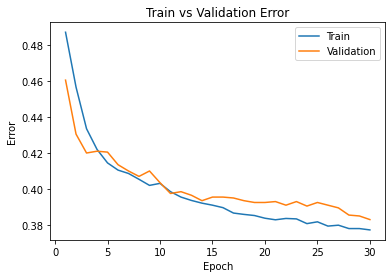

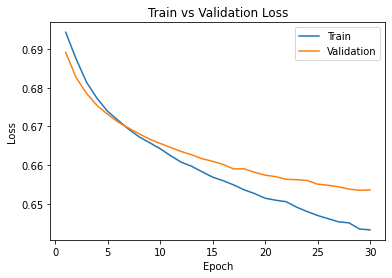

In [ ]:
# Training
pigeon = Pigeon()
train_net(pigeon, batch_size=512, learning_rate=0.001)
model_path = get_model_name("pigeon", batch_size=512, learning_rate=0.001, epoch=29)
plot_training_curve(model_path)

In [ ]:
# Testing
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=512)
criterion = nn.BCEWithLogitsLoss()
err, loss = evaluate(pigeon, test_loader, criterion)
print("The test classification error is", err, "and the test loss is", loss)

Files already downloaded and verified
Files already downloaded and verified
The test classification error is 0.381 and the test loss is 0.6476677060127258


**Answer:**

As shown in the code above, the best test classification error achieved using a 2-layer ANN architecture is `0.381`. This is much higher compared to the `0.304` test classification error produced using the CNN model. Therefore, a CNN architecture is more suited for this problem of cats vs dogs classification.